Cluster ordering function taken from Ishimoto 2018 Sci Rep

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os

In [77]:
# --- Configuration ---
BOX_SIZE = 500.0  # Must match the box size of the simulation
DR = BOX_SIZE/200          # Bin width for distance (resolution)
R_MAX = BOX_SIZE/4     # Max distance to calculate correlation for

In [107]:
def compute_rdf_pbc(coords1, coords2, box_size, r_range):
    """
    Computes the 2D Radial Distribution Function g(r) with Periodic Boundary Conditions.
    
    Args:
        coords1: (N, 2) array of positions for reference particles (Type A)
        coords2: (M, 2) array of positions for target particles (Type B)
        box_size: Side length of the simulation box
        r_range: Array of bin edges for distance
    """
    
    # 1. Calculate vector differences (N x M x 2) using broadcasting
    delta = coords1[:, np.newaxis, :] - coords2[np.newaxis, :, :]
    
    # 2. Apply Periodic Boundary Conditions (Minimum Image Convention)
    delta = delta - box_size * np.round(delta / box_size)
    
    # 3. Calculate squared distances
    dists_sq = np.sum(delta**2, axis=2)
    dists = np.sqrt(dists_sq)
    
    # 4. Flatten
    dists_flat = dists.flatten()
    dists_flat = dists_flat[dists_flat > 1e-6] # Remove self-interactions
    
    # 5. Histogram counts
    counts, bin_edges = np.histogram(dists_flat, bins=r_range)
    
    # 6. Normalization by Ideal Gas Density (Area of shells)
    # Area of 2D shell = pi * (r_outer^2 - r_inner^2)
    areas = np.pi * (r_range[1:]**2 - r_range[:-1]**2)
    
    # Global density of Type B
    rho_2 = len(coords2) / (box_size**2)
    
    # Expected count if particles were randomly distributed
    # Density_target * Area_shell
    expected_counts = rho_2 * areas
    
    # Calculate g(r)
    g_r = counts / (len(coords1) * expected_counts)       
    
    return g_r

def analyze_and_plot(filename, times_to_analyze, cmap, heterogenous=False):
    """Loads a parquet file, computes correlations, and plots them."""
    print(f"--- Analyzing: {filename} ---")
    df = pd.read_parquet(filename)
    
    # Setup bins
    r_bins = np.arange(0, R_MAX + DR, DR)

    # Get bin centers for plotting
    r = (r_bins[:-1] + r_bins[1:]) / 2

    # Prepare Plot
    fig, ax = plt.subplots(3 if heterogenous else 1, 1, figsize=(6, 5*(3 if heterogenous else 1)), sharex=True, sharey=True)
    if not heterogenous:
        ax = [ax]
    
    for i, t in enumerate(times_to_analyze):
        df_t = df[df['Time'] == t]

        if not heterogenous:
            # Extract positions
            pos_all = df_t[['Pos_X', 'Pos_Y']].values
    
            # --- A. All-to-All Correlation ---
            # Useful for homogeneous simulations
            if len(pos_all) > 0:
                g = compute_rdf_pbc(pos_all, pos_all, BOX_SIZE, r_bins)
                ax[0].plot(r, g, label=f't={t}', color=cmap((i+1)/len(times_to_analyze)))
                ax[0].set_title(f"File: {filename.split(".")[0]}")

        if heterogenous:
            # Extract positions
            pos_motile = df_t[df_t['Type'] == 'motile'][['Pos_X', 'Pos_Y']].values
            pos_sub = df_t[df_t['Type'] == 'submotile'][['Pos_X', 'Pos_Y']].values
            
            # --- B. Specific Correlations (for Heterogeneous) ---
            # 1. Motile-Motile
            if len(pos_motile) > 10:
                g = compute_rdf_pbc(pos_motile, pos_motile, BOX_SIZE, r_bins)
                ax[0].plot(r, g, label=f't={t}', color=cmap((i+1)/len(times_to_analyze)))
                ax[0].set_title('Motile-Motile')
                
            # 2. Submotile-Submotile
            if len(pos_sub) > 10:
                g = compute_rdf_pbc(pos_sub, pos_sub, BOX_SIZE, r_bins)
                ax[1].plot(r, g, label=f't={t}', color=cmap((i+1)/len(times_to_analyze)))
                ax[1].set_title('Submotile-Submotile')
                
            # 3. Motile-Submotile (Cross Correlation)
            if len(pos_motile) > 0 and len(pos_sub) > 0:
                g = compute_rdf_pbc(pos_motile, pos_sub, BOX_SIZE, r_bins)
                ax[2].plot(r, g, label=f't={t}', color=cmap((i+1)/len(times_to_analyze)))
                ax[2].set_title('Motile-Submotile')

            plt.suptitle(f"File: {filename.split(".")[0]}")

    for i in ax:
        i.axhline(1.0, color='gray', linestyle=':', alpha=0.5) # Reference line
        i.legend()
        i.set_xlabel("Distance $r$")
        i.set_ylabel("$C_*(r)$")

    plt.tight_layout()

def analyse_all_time(filename, heterogenous=False):
    print(f"--- Analyzing: {filename} ---")
    df = pd.read_parquet(filename)
    times_to_analyze = df['Time'].unique()
    
    # Setup bins
    r_bins = np.arange(0, R_MAX + DR, DR)
    g_list = []
    
    for t in times_to_analyze:
        df_t = df[df['Time'] == t]

        if not heterogenous:
            # Extract positions
            pos_all = df_t[['Pos_X', 'Pos_Y']].values
    
            # --- A. All-to-All Correlation ---
            # Useful for homogeneous simulations
            if len(pos_all) > 0:
                g_list.append({
                    "Time": t,
                    "Cluster ordering": compute_rdf_pbc(pos_all, pos_all, BOX_SIZE, r_bins)
                })

        if heterogenous:
            # Extract positions
            pos_motile = df_t[df_t['Type'] == 'motile'][['Pos_X', 'Pos_Y']].values
            pos_sub = df_t[df_t['Type'] == 'submotile'][['Pos_X', 'Pos_Y']].values
            
            # --- B. Specific Correlations (for Heterogeneous) ---
            # 1. Motile-Motile
            if len(pos_motile) > 10:
                g_mm = compute_rdf_pbc(pos_motile, pos_motile, BOX_SIZE, r_bins)
                
            # 2. Submotile-Submotile
            if len(pos_sub) > 10:
                g_ss = compute_rdf_pbc(pos_sub, pos_sub, BOX_SIZE, r_bins)
                
            # 3. Motile-Submotile (Cross Correlation)
            if len(pos_motile) > 0 and len(pos_sub) > 0:
                g_ms = compute_rdf_pbc(pos_motile, pos_sub, BOX_SIZE, r_bins)

            g_list.append({
                "Time": t,
                "Cluster ordering: Motile-Motile": g_mm,
                "Cluster ordering: Submotile-Submotile": g_ss,
                "Cluster_ordering: Motile-Submotile": g_ms
            })

    return g_list

In [102]:
os.chdir("C:/Users/yzlee/Desktop/large_files")
simulation_files = glob.glob("*.parquet")
print(simulation_files)

['heterogeneous_simulation_100motile_100submotile_phaselock=False.parquet', 'heterogeneous_simulation_100motile_100submotile_phaselock=True.parquet', 'homogeneous_simulation_200motile_phaselock=False.parquet', 'homogeneous_simulation_200motile_phaselock=True.parquet']


In [103]:
df_test = pd.read_parquet(simulation_files[0])
total_points = len(df_test['Time'].unique())
print(total_points)

10015


In [104]:
no_of_points = 5
time_points = df_test['Time'].unique()[[round(i*(total_points-1)/(no_of_points-1)) for i in range(no_of_points)]]
blues = plt.get_cmap('Blues')
print(time_points)

[   0.   250.4  500.7  751.  1001.4]


--- Analyzing: homogeneous_simulation_200motile_phaselock=False.parquet ---
--- Analyzing: homogeneous_simulation_200motile_phaselock=True.parquet ---


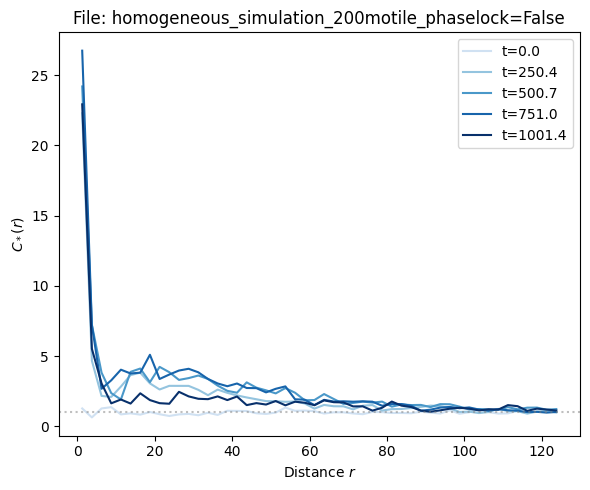

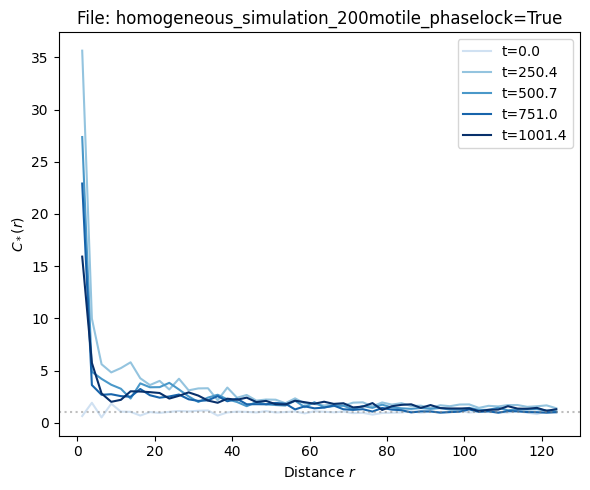

In [105]:
# --- Main Execution Loop ---
for f in simulation_files[-2:]:
    analyze_and_plot(f, time_points, blues)

--- Analyzing: heterogeneous_simulation_100motile_100submotile_phaselock=False.parquet ---
--- Analyzing: heterogeneous_simulation_100motile_100submotile_phaselock=True.parquet ---


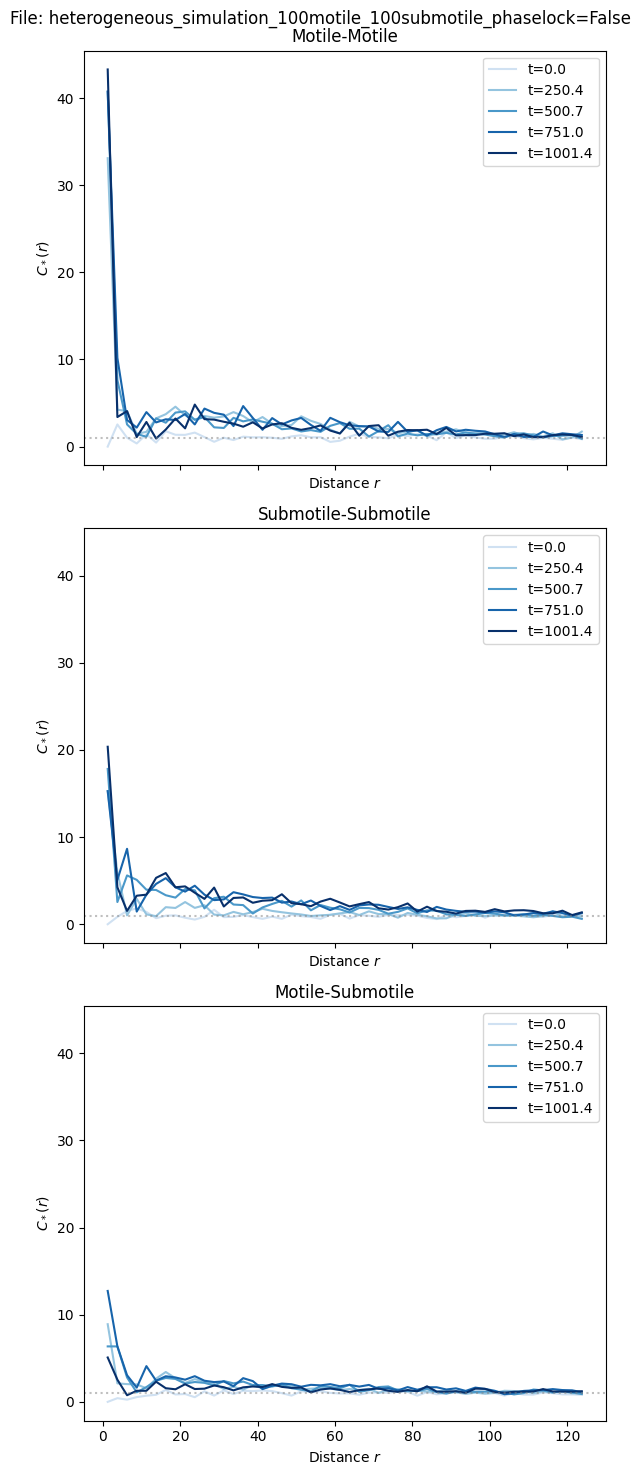

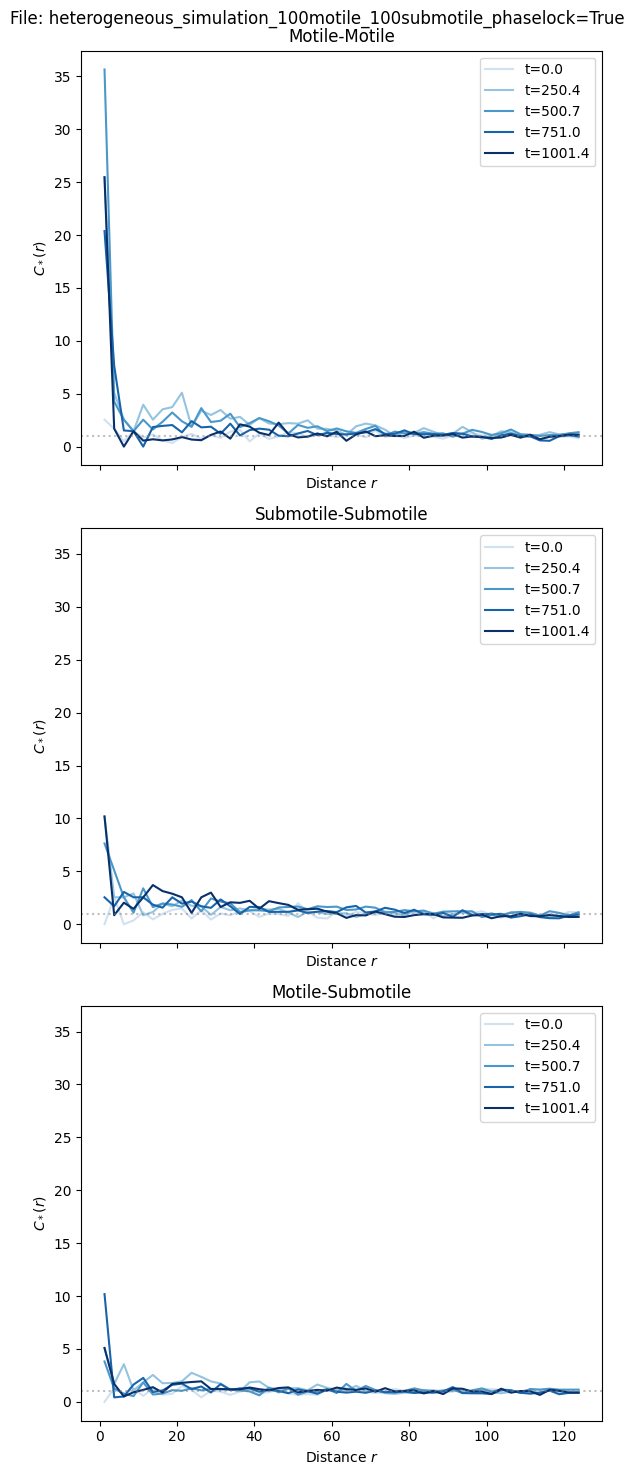

In [106]:
for f in simulation_files[:2]:
    analyze_and_plot(f, time_points, blues, heterogenous=True)

In [108]:
for f in simulation_files[-2:]:
    df = pd.DataFrame(analyse_all_time(f))
    df.to_parquet(f"{f.split(".")[0]}_correlation.parquet", compression='zstd')

--- Analyzing: homogeneous_simulation_200motile_phaselock=False.parquet ---
--- Analyzing: homogeneous_simulation_200motile_phaselock=True.parquet ---
